# Gaussian Hidden Markov Models

In [1]:
# Set your working directory
import sys
sys.path.insert(0, "../models/")

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from HMM import HMM
from posteriors import wishart,norm, dirichlet, simul_s, _Phi,order, apply_by_group
from simulation import simul_gauss

## We will fit a gaussian HMM on the popular iris dataset
This example demonstrate that the standard mixtures are included in HMM models

A  gaussian HMM is made of :
* A posterior `normal-inverse_wishart` distribution over $\theta = (\mu,\Sigma) \in IR^{2xd}xIR^{2xdxd}$; where $d$ = dim of the gaussian vectors
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by defining the posterior of $\theta = \left(\mu,\Sigma\right)$

In [4]:
tDictDist = {"mu": norm(), "omega_inv": wishart()} # Note that, \0mega^{-1} is simulated instead \Omega

#Let set the default parameters

d = 4 # dim of our gaussian vectors
k = 3 # Number of components
nu = np.array([10]*k) # Degree of freedoms of the prior of \Omega
omega_inv = np.array([np.eye(d)]*k)/10 # Cov matrix of the prior of \Omgea

mu =  np.array([np.zeros(d)]*k) # Mean of the prior over  \mu
sigma = 10*np.array([np.eye(d)]*k) # Cov matrix of the prior over \mu

tDictDist["mu"]._set_default( mu0 = mu, sigma0_inv = np.linalg.inv(sigma))
tDictDist["omega_inv"]._set_default(nu0 = nu, omega0_inv = omega_inv)

In [5]:
sDist = simul_s(func = _Phi) # S distribution

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set_default(a = 50*np.ones((k,k))/k)

# The gaussian mixture on iris dataset

Let's simulate an artificial gaussian mixture

In [7]:
# Load the iris dataset
from sklearn import datasets
iris = datasets.load_iris()
iris.data.shape

(150, 4)

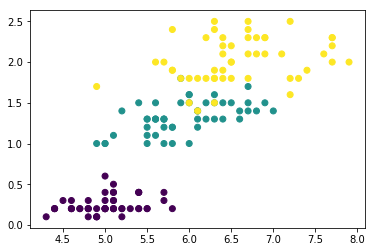

In [8]:
plt.scatter(iris.data[:, 0], iris.data[:, 3], c = iris.target)  # Our clusters

Now, we're gonna define the gHMM

In [9]:
shuffle = np.arange(len(iris.data))
np.random.shuffle(shuffle)

target = iris.target[:][shuffle]
target2 = pd.Categorical(target).codes

In [10]:
Y = iris.data[:][shuffle] # Obs
S = np.random.choice(k, len(Y)) # Initial states
P = np.ones((k,k))/k # Initial transition matrix
mu =  np.array([ np.zeros(d)]*k) # Initial 'mean'
omega_inv =  np.array([np.eye(d)]*k)/10 # Initial cov matrix, any !
Theta = {"mu": mu , "omega_inv": omega_inv } # Initial parameters sample

In [11]:
ghmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S , Theta = Theta, P = P )

In [12]:
np.random.seed(111)
ghmm.run(3000) # Start the gibbs sampler n-times

Time : 2019-01-30  23:13:10   Elapsed : 0.00 min.  N_iter : 0000   Remain : 3000   %Remain : 100%


../models\posteriors.py:83: RuntimeWarning: invalid value encountered in true_divide
  r = np.argsort(u/v)


Time : 2019-01-30  23:13:21   Elapsed : 0.17 min.  N_iter : 0500   Remain : 2500   %Remain : 83%
Time : 2019-01-30  23:13:32   Elapsed : 0.36 min.  N_iter : 1000   Remain : 2000   %Remain : 66%
Time : 2019-01-30  23:13:47   Elapsed : 0.62 min.  N_iter : 1500   Remain : 1500   %Remain : 50%
Time : 2019-01-30  23:14:04   Elapsed : 0.90 min.  N_iter : 2000   Remain : 1000   %Remain : 33%
Time : 2019-01-30  23:14:24   Elapsed : 1.22 min.  N_iter : 2500   Remain : 0500   %Remain : 16%


## Checking for auto-correlation in the chain

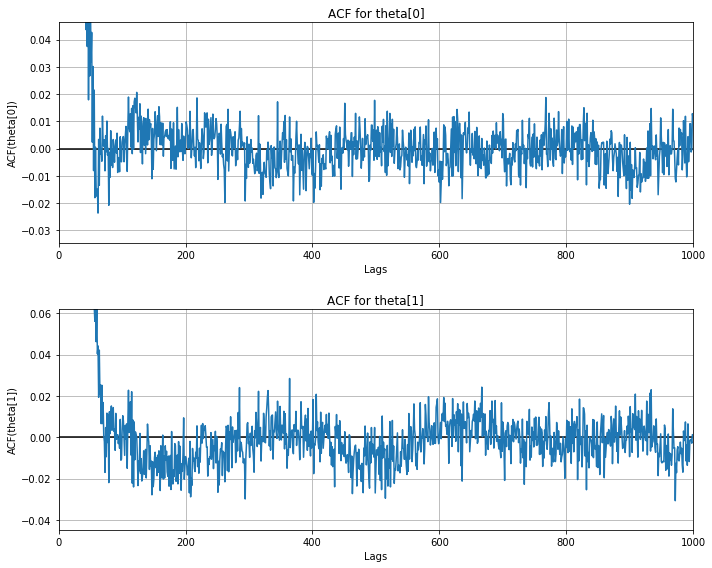

In [14]:
from utils import plot_ACF

mus = np.array([x["mu"].flatten() for x in ghmm.H["Theta"]]) # Only plotting for mu

plot_ACF(mus[:, :2], nlags = 1000)

We can see that the ACFs quickly converge to zero, the chain seems to be generated quickly

# Can we recover the true clusters ? Let's see !

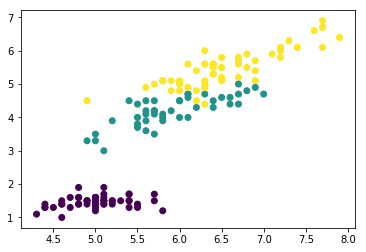

In [15]:
plt.scatter(Y[:, 0], Y[:,2], c = ghmm.H["S"][-5])

In [16]:
# Instead for taking just the last sample as prediction, we can compute the 
# mode of predicted states for each data point
Sgmm = np.array(ghmm.H["S"][-200:]) # We just consider latest steps in our simulation
Sgmm = np.apply_along_axis(np.bincount, 0, Sgmm, minlength = k )
Sgmm = Sgmm.argmax(0)
Sgmm[:10]

array([0, 0, 2, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

In [17]:
pd.crosstab(target2, Sgmm)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,45,5
2,0,0,50


In [18]:
ghmm.tDictDist["mu"].rvs() # We can sample mu & omega distribution

array([[5.02115319, 3.4451092 , 1.45651445, 0.23770783],
       [5.95027488, 2.77538388, 4.25853116, 1.30501273],
       [6.32264272, 2.85336271, 5.28911902, 1.93597356]])

In [19]:
np.array([history["mu"] for history in ghmm.H["Theta"][-200::]]).mean(0) # Mean predicted value for mu

array([[5.00823672, 3.41717106, 1.46212331, 0.24407289],
       [5.90241882, 2.7702737 , 4.1921591 , 1.29811287],
       [6.5429935 , 2.94605539, 5.4783566 , 1.98955297]])

In [20]:
np.array(ghmm.H["P"][-200::]).mean(0) # Mean transition matrix

array([[0.38392316, 0.28511166, 0.33096517],
       [0.32227337, 0.33799843, 0.3397282 ],
       [0.29510442, 0.33748641, 0.36740917]])

###  Comparison with Kmeans

In [21]:
from sklearn.cluster import KMeans

In [22]:
km = KMeans(n_clusters= k, n_init= 50)

In [23]:
km.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### As we can see it, our model performs better than Kmeans : 5 vs 16 misclassified observations

In [24]:
pd.crosstab(target2, km.labels_)

col_0,0,1,2
row_0,,,
0,0,50,0
1,48,0,2
2,14,0,36
